<a href="https://colab.research.google.com/github/JuanBalde/Juan-y-Patricio-Facultad/blob/main/TP_5_Cin%C3%A9tica_de_Oxidaci%C3%B3n_de_loduro_por_Persulfato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import pandas as pd
import statsmodels.api as sm
import seaborn as sns


########################################
#   EXPORTAR FIGURAS A LATEX
#########################################
textwidth=512.14963 #pt lo que sale en latex si escribo \the\textwidth
pt_to_inch=(1/72.27)
textwidth*=pt_to_inch
textheight=29.4-0.15-0.15 #alto a4 -15mm de marge superior e inferior
textheight/=2.54 #paso de cm a pulgadas

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["mathtext.fontset"]='dejavuserif'

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')


from google.colab import files #para descargar la imagen


<ipython-input-4-0830787c17a8>:23: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [ ]:
def Plot_CI(X:list,CI_lower:list,CI_upper:list,Color='gray',Transparencia=0.4,Label=''):
    """
    X : los X del array de intervalos de confianza
    CI_lower : El intervalo de confianza inferior
    CI_upper : El intervalo de confianza superior
    Color : opcional, color de relleno. Defaul= gris
    Transparecnia: opcional, default=0.4
    Label : opcional, etiqueta para legend
    """
    #plt.plot(X,CI_upper,color=Color)
    #plt.plot(X,CI_lower,color=Color)
    plt.fill_between(
        x=X,
        y1=CI_lower,
        y2=CI_upper,
        color=Color,
        alpha=Transparencia,
        label=Label
    )

In [ ]:
MRKCl = 74.5513 # g/mol
MRNa2SO4 = 142.04 # g/mol (Anhidro)

dfv = pd.DataFrame()
dfv["V K2S2O8 (ml)"] = np.array([5, 3.5, 2.5, 5, 5]) # ml
dfv["V KI (ml)"] = np.array([5, 5, 5, 3.5, 2.5]) # ml
dfv["V Na2S2O3 (ml)"] = np.array([2, 2, 2, 2, 2]) # ml
dfv["V Almidon (ml)"] = np.array([1, 1, 1, 1, 1]) # ml
dfv["V Sal para FI (ml)"] = 13 - (dfv["V K2S2O8 (ml)"] + dfv["V KI (ml)"] + dfv["V Na2S2O3 (ml)"] + dfv["V Almidon (ml)"]) # ml

C0K2S2O8 = 0.1 # M
C0KI = 0.1 # M
C0tio = 0.01 # M

dfv

,V K2S2O8 (ml),V KI (ml),V Na2S2O3 (ml),V Almidon (ml),V Sal para FI (ml)
0,5.0,5.0,2,1,0.0
1,3.5,5.0,2,1,1.5
2,2.5,5.0,2,1,2.5
3,5.0,3.5,2,1,1.5
4,5.0,2.5,2,1,2.5


 $I_0= 0.5*(C_{tio \ 0}*2^2 + C_{KI \ 0} + C_{per \ 0}*2^2)$

 $I_i= 0.5*(C_{tio \ i}*2^2 + C_{KI \ i} + C_{per \ i}*2^2)$

 $I_{faltante \ en \ experiencia \ i}=I_0 - Ii$

esa I faltatante lo agrego con la sal

$I_{sal}=0.5*(C_{sal}*z_{sal}^2)=I_{faltante}$

despejo $C_{sal}$

$C_{sal} = \frac{2*I_{faltante}}{z_{sal}^2}$

In [ ]:
dfc = pd.DataFrame()
Vf = 13 # ml

dfc["C K2S2O8 (M)"] = C0K2S2O8*dfv["V K2S2O8 (ml)"]/Vf # M
dfc["C KI (M)"] = C0KI*dfv["V KI (ml)"]/Vf # M
dfc["C Na2S2O3 (M)"] = C0tio*dfv["V Na2S2O3 (ml)"]/Vf # M
dfc["FI (M)"] = 1/2*(dfc["C K2S2O8 (M)"]*2**2 + dfc["C KI (M)"] + dfc["C Na2S2O3 (M)"]*2**2) # M

FI_falta=dfc["FI (M)"].iloc[0]-dfc["FI (M)"]
dfc["FI falta"]=FI_falta
dfc["C KCl (M)"] = 2*FI_falta/(1**2)
dfc["C Na2SO4 (M)"] = 2*FI_falta/(2**2)

#dfc["FI Final KCl (M)"] = 1/2*(dfc["C K2S2O8 (M)"]*2**2 + dfc["C KI (M)"] + dfc["C Na2S2O3 (M)"]*2**2 + dfc["C KCl (M)"] + dfc["C KCl (M)"]) # M
#dfc["FI Final Na2SO4 (M)"] = 1/2*(dfc["C K2S2O8 (M)"]*2**2 + dfc["C KI (M)"] + dfc["C Na2S2O3 (M)"]*2**2 + 2*dfc["C Na2SO4 (M)"] + dfc["C Na2SO4 (M)"]*2**2) # M

nKCl = dfc["C KCl (M)"]*Vf/1000
nNa2SO4 = dfc["C Na2SO4 (M)"]*Vf/1000

mKCl = nKCl*MRKCl
mNa2SO4 = nNa2SO4*MRNa2SO4

dfc["Masa KCl (g)"] = mKCl
dfc["Masa Na2SO4 (g)"] = mNa2SO4

FI_con_KCl = dfc["FI (M)"] + (0.5*(dfc['C KCl (M)']))
FI_con_Na2SO4 = dfc["FI (M)"] + 0.5*(dfc['C Na2SO4 (M)']*(2**2))
FI0=dfc["FI (M)"].iloc[0]


dfc["FI_final_KCl"]=FI_con_KCl
dfc["FI_final_sulfato"]=FI_con_Na2SO4
dfc

,C K2S2O8 (M),C KI (M),C Na2S2O3 (M),FI (M),FI falta,C KCl (M),C Na2SO4 (M),Masa KCl (g),Masa Na2SO4 (g),FI_final_KCl,FI_final_sulfato
0,0.038462,0.038462,0.001538,0.099231,0.000000,0.000000,0.000000,0.000000,0.000000,0.099231,0.099231
1,0.026923,0.038462,0.001538,0.076154,0.023077,0.046154,0.011538,0.044731,0.021306,0.099231,0.099231
2,0.019231,0.038462,0.001538,0.060769,0.038462,0.076923,0.019231,0.074551,0.035510,0.099231,0.099231
3,0.038462,0.026923,0.001538,0.093462,0.005769,0.011538,0.002885,0.011183,0.005326,0.099231,0.099231
4,0.038462,0.019231,0.001538,0.089615,0.009615,0.019231,0.004808,0.018638,0.008878,0.099231,0.099231


# Resultados aqui:

In [ ]:
df = pd.DataFrame()
# Resultados de variar concentraciones:
EXP1 = np.array([6*60 + 50, 13*60 + 39, 22*60 + 21, 9*60 + 57, 12*60 + 59]) # s
df["dt (s)"] = EXP1 # s
err_t = 3 # s
df["Velocidad (M/s)"] = dfc["C Na2S2O3 (M)"]/df["dt (s)"]/2 # M/s
err_Vel = abs(-dfc["C Na2S2O3 (M)"]/df["dt (s)"]**2/2)*err_t
df["err_vel"]=err_Vel
# Resultados al variar la fuerza ionica:
EXP2 = np.array([8*60 + 7, 6*60 + 54, 5*60 + 54]) # s

Masa_AgregadaKCl = np.array([0, 0.034, 0.081])
err_Masa = 0.001

Moles_Agregados = Masa_AgregadaKCl/MRKCl
err_Moles = err_Masa/MRKCl

Concentracion_Agregada = Moles_Agregados/15*1000 # mol/ml a mol/L
err_Concentracion = err_Moles/15*1000

FI_Agregada = 0.5*Concentracion_Agregada
err_FI = 0.5*err_Concentracion

# Resultados de variar la temperatura:
EXP3 = np.array([9*60 + 57, 4*60 + 45, 3*60 + 42, 2*60 + 31, 1*60 + 20]) # s
T = np.array([20, 30, 35, 40, 50]) + 273 # k
df.to_csv('eq_velocidad.csv',index=False)
df

,dt (s),Velocidad (M/s),err_vel
0,410,1.876173e-06,1.372809e-08
1,819,9.392317e-07,3.440409e-09
2,1341,5.736247e-07,1.283277e-09
3,597,1.288494e-06,6.474843e-09
4,779,9.874593e-07,3.802796e-09


# Efecto de la fuerza lónica:
Repetir el experimento 1 pero a mayores fuerzas ionicas

In [ ]:
Vf_FI = 15

FI_Inicial = dfc["FI (M)"].iloc[0]*Vf/Vf_FI
FI_1 = dfc["FI (M)"].iloc[0]*Vf/Vf_FI*3/2
FI_2 = dfc["FI (M)"].iloc[0]*Vf/Vf_FI*7/4

FIAgregado_1 = FI_1 - FI_Inicial
FIAgregado_2 = FI_2 - FI_Inicial

# Para la primera solucion a armar

C_KCl_1 = 2*FIAgregado_1
nKCl_1 = C_KCl_1*Vf/1000

C_Na2SO4_1 = 2*FIAgregado_1/(2**2)
nNa2SO4_1 = C_Na2SO4_1*Vf/1000

mKCl_1 = nKCl_1*MRKCl
mNa2SO4_1 = nNa2SO4_1*MRNa2SO4

print(f"Para la primera solucion se debe agregar {Vf_FI - Vf} ml de agua con {mKCl_1:.4f} g de KCl o {mNa2SO4_1:.4f} g de Na2SO4")

# Para la segunda solucion a armar
C_KCl_2 = 2*FIAgregado_2
nKCl_2 = C_KCl_2*Vf/1000

C_Na2SO4_2 = 2*FIAgregado_2/4
nNa2SO4_2 = C_Na2SO4_2*Vf/1000

mKCl_2 = nKCl_2*MRKCl
mNa2SO4_2 = nNa2SO4_2*MRNa2SO4

print(f"Para la segunda solucion se debe agregar {Vf_FI - Vf} ml de agua con {mKCl_2:.4f} g de KCl o {mNa2SO4_2:.4f} g de Na2SO4")

Para la primera solucion se debe agregar 2 ml de agua con 0.0833 g de KCl o 0.0397 g de Na2SO4
Para la segunda solucion se debe agregar 2 ml de agua con 0.1250 g de KCl o 0.0596 g de Na2SO4



# Tratamiento de resultado:


## 1) Calcular los órdenes de reacción con respecto a ioduro y persulfato.

$\ln \nu = \ln k + m \ln C_p + n \ln C_{I^-}$

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

m = 1.7	 +/- 0.1, r2 = 0.99


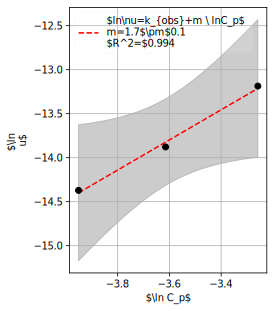

In [ ]:
# Calcular orden m
C0p = 0.1 # M
Vp = dfv["V K2S2O8 (ml)"][0:3]
Cp = dfc["C K2S2O8 (M)"][0:3]

vel_p=df["Velocidad (M/s)"][0:3]
lnvelp=np.log(vel_p)
err_lnvelp=(1/vel_p)*err_Vel[0:3]

x = np.log(Cp)
y = lnvelp

ajuste= sm.OLS(y,sm.add_constant(x)).fit()
ord,pend= ajuste.params
err_ord, err_pend= ajuste.bse
r2=ajuste.rsquared

x_ci = np.linspace(x.min(),x.max(),50)
frame = ajuste.get_prediction(sm.add_constant(x_ci)).summary_frame(alpha=0.05)
ci_low = frame.mean_ci_lower
ci_up = frame.mean_ci_upper


m = pend
err_m = err_pend
####################################################################################################
#plt.plot(x, y, "ko")


fig,axes =plt.subplots()
plt.errorbar(x,y,yerr=err_lnvelp,fmt="ko")
plt.grid()
plt.xlabel("\$\ln C_p\$")
plt.ylabel("\$\ln \nu\$")


linea_x=np.array([x.min(),x.max()])
leyenda_ajuste=r"\$ln\nu=k_{obs}+m \ lnC_p\$"+f"\n m={m:.1f}"+r"\$\pm\$"+f"{err_m:.1g}"
leyenda_ajuste+="\n"+r"\$R^2=\$"+f"{r2:.3f}"
plt.plot(linea_x,linea_x*pend+ord , 'r--',label=leyenda_ajuste)
Plot_CI(X=x_ci,CI_lower=ci_low,CI_upper=ci_up)
plt.legend(loc='upper left',fancybox=True, framealpha=0.1)
fig.set_figwidth(textwidth/2)
plt.savefig('grafico_para_m.svg')
files.download('grafico_para_m.svg')

print(f"{m = :.1f}\t +/- {err_m:.1f}, {r2 = :.2f}")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

n = 0.93 +/- 0.08, r2 = 0.99 


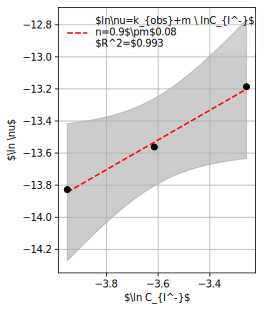

In [ ]:
# Calcular orden n
C0I = 0.1 # M
VI = dfv["V KI (ml)"].iloc[[0,3,4]]
CI = dfc["C KI (M)"].iloc[[0,3,4]]

x = np.log(CI)
y = np.log(df["Velocidad (M/s)"].iloc[[0,3,4]])
err_y = (1/df["Velocidad (M/s)"].iloc[[0,3,4]])*df["err_vel"].iloc[[0,3,4]]

ajuste= sm.OLS(y,sm.add_constant(x)).fit()
ord,pend= ajuste.params
err_ord, err_pend= ajuste.bse
r2=ajuste.rsquared

x_ci = np.linspace(x.min(),x.max(),50)
frame = ajuste.get_prediction(sm.add_constant(x_ci)).summary_frame(alpha=0.05)
ci_low = frame.mean_ci_lower
ci_up = frame.mean_ci_upper

n = pend
err_n = err_pend

#plt.plot(x, y, "ko")
fig,axes = plt.subplots()
plt.errorbar(x,y,yerr=err_y,fmt="ko")
linea_x=np.array([x.min(),x.max()])


leyenda_ajuste=r"\$ln\nu=k_{obs}+m \ lnC_{I^-}\$"+f"\n n={n:.1f}"+r"\$\pm\$"+f"{err_n:.1g}"
leyenda_ajuste+="\n"+r"\$R^2=\$"+f"{r2:.3f}"
plt.plot(linea_x,linea_x*pend+ord , 'r--',label=leyenda_ajuste)
Plot_CI(X=x_ci,CI_lower=ci_low,CI_upper=ci_up)

plt.grid()
plt.xlabel(r"\$\ln C_{I^-}\$")
plt.ylabel(r"\$\ln \nu\$")

plt.legend(loc='upper left',fancybox=True, framealpha=0.1)
fig.set_figwidth(textwidth/2)
plt.savefig('grafico_para_n.svg')
files.download('grafico_para_n.svg')

print(f"{n = :.2f} +/- {err_n:.1g}, {r2 = :.2f} ")

## Usamos k=m=1

In [ ]:
m=n=1

## 2) Calcular la constante de velocidad a temperatura ambiente.

$\nu = kC_p^mC_{I^-}^n$ Entonces $k = \frac{\nu}{C_p^mC_{I^-}^n}$

In [ ]:
k = df["Velocidad (M/s)"]/(dfc["C K2S2O8 (M)"]**m*dfc["C KI (M)"]**n)
err_k = np.std(k)
print(f"k es {k.to_list()},\n de preferencia los 5 valores son iguales o similares, o sea,\n promediemos: {np.mean(k):.2g} +/- {np.mean(err_k):.1g}, std={np.std(k):.2g}")
print("\n")

lnk = np.log(df["Velocidad (M/s)"]) - m*np.log(dfc["C K2S2O8 (M)"]) - n*np.log(dfc["C KI (M)"])
err_lnk = np.std(lnk)
print(f"ln(k) es {np.exp(np.array(lnk))},\n de preferencia los 5 valores son iguales o similares, o sea, promediemos: {np.mean((lnk)):.3g} +/- {np.mean(err_lnk):.1g}")

print()

k es [0.001268292682926829, 0.0009070294784580499, 0.0007755406413124532, 0.0012443168222062693, 0.0013350449293966624],
 de preferencia los 5 valores son iguales o similares, o sea,
 promediemos: 0.0011 +/- 0.0002, std=0.00022


ln(k) es [0.00126829 0.00090703 0.00077554 0.00124432 0.00133504],
 de preferencia los 5 valores son iguales o similares, o sea, promediemos: -6.83 +/- 0.2



### Para te parcialito
$S_2O_8^{2-} + 2I^- \longrightarrow 2SO_4^{2-} + I_2\$

$2S_2O_3^{2-} + I_2 \longrightarrow S_4O_6^{2-} + 2I^-$

$v_1 = k_1[S_2O_8^{2-}][I^-]$

$v_2 = k_2[I_2][S_2O_3^{2-}]$

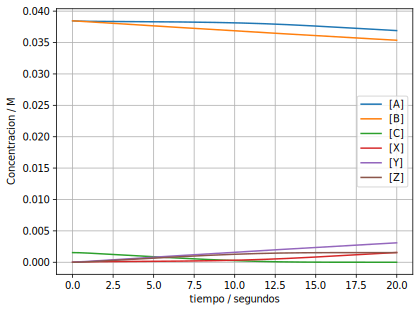

In [ ]:
tsteps = 2000 # numero de pasos de simulación
dt = 0.01 # intervalo de tiempo en segundos

k1 = np.average(k)  # constante
k2 = k1*10000     # constante

t = 0.0   # el tiempo cero es cero...

I = dfc["C KI (M)"][0] # concentracion inicial de A en M
Per = dfc["C K2S2O8 (M)"][0] # concentracion inicial de B en M
Tio = dfc["C Na2S2O3 (M)"][0]   # concentracion inicial de C en M
I2 = 0
Sulf = 0
Bisulf = 0

A = I
B = Per
C = Tio
X = I2
Y = Sulf
Z = Bisulf

Alist = [] # lista de concentraciones de A vs t
Blist = [] # lista de concentraciones de B vs t
Clist = [] # lista de concentraciones de C vs t
Xlist = [] # lista de concentraciones de X vs t
Ylist = [] # lista de concentraciones de Y vs t
Zlist = [] # lista de concentraciones de Z vs t
tlist = [] # lista de tiempos

for i in range(0, tsteps):
    tlist.append(t)
    Alist.append(A)
    Blist.append(B)
    Clist.append(C)
    Xlist.append(X)
    Ylist.append(Y)
    Zlist.append(Z)

    t = t + dt # adelanto tiempo
    dA = -k1*B*A + k2*X*C
    dB = -k1*B*A
    dC = -k2*X*C
    dX = k1*B*A - k2*X*C
    dY = k1*B*A
    dZ = k2*X*C

    A = A + dA # adelanto concentraciones
    B = B + dB # adelanto concentraciones
    C = C + dC # adelanto concentraciones
    X = X + dX
    Y = Y + dY
    Z = Z + dZ

plt.plot(tlist, Alist, label='[A]')
plt.plot(tlist, Blist, label='[B]')
plt.plot(tlist, Clist, label='[C]')
plt.plot(tlist, Xlist, label='[X]')
plt.plot(tlist, Ylist, label='[Y]')
plt.plot(tlist, Zlist, label='[Z]')
plt.xlabel('tiempo / segundos') # Rótulo de eje horizontal
plt.ylabel('Concentracion / M') #Rótulo de eje vertical
plt.legend() #Para mostrar la leyenda de cada línea graficada
plt.grid()
plt.show()

## 3) Calcular la energía de activación y el factor preexponencial.

Arrhenius: $k = A\exp(-\frac{E_a}{RT})$ Por lo tanto $lnk = ln(A)-\frac{E_a}{R}\frac{1}{T}$



La energia de activacion es (52430 +/- 1342) J/mol y 
 el factor preexponencial es (2.753955e+06 +/- 1e+06)=
r2 = 1.00


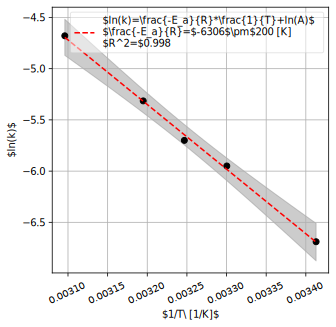

In [ ]:
R = 8.31446261815324 # J/k mol

VelocidadEXP3 = dfc["C Na2S2O3 (M)"][3]/EXP3/2
k = VelocidadEXP3/(dfc["C K2S2O8 (M)"][3]**m*dfc["C KI (M)"][3]**n)

x = 1/T
y = np.log(k)


ajuste= sm.OLS(y,sm.add_constant(x)).fit()
ord,pend= ajuste.params
err_ord, err_pend= ajuste.bse
r2 = ajuste.rsquared

x_ci = np.linspace(x.min(),x.max(),50)
frame = ajuste.get_prediction(sm.add_constant(x_ci)).summary_frame(alpha=0.01)
ci_low = frame.mean_ci_lower
ci_up = frame.mean_ci_upper

linea_x=np.array([x.min(),x.max()])

fig,axes = plt.subplots()
plt.plot(x, y, "ko")
plt.grid()
plt.xlabel("\$1/T\ [1/K]\$")
plt.ylabel("\$ln(k)\$")
plt.xticks(rotation=25)

ajuste_label=r"\$ln(k)=\frac{-E_a}{R}*\frac{1}{T}+ln(A)\$"+"\n"+r"\$\frac{-E_a}{R}=\$"
ajuste_label+=f"{pend:.0f}"+"\$\pm\$"+f"{200} [K]\n"+r"\$R^2=\$"+f"{r2:.3f}"
plt.plot(linea_x,linea_x*pend+ord , 'r--',label=ajuste_label)
Plot_CI(X=x_ci,CI_lower=ci_low,CI_upper=ci_up)
plt.legend(loc='upper right',fancybox=True, framealpha=0.5)
fig.set_figwidth(0.7*textwidth)
plt.savefig('ea.svg',bbox_inches='tight')
#files.download('ea.svg')

Ea = -pend*R # J/mol
err_Ea = err_pend*R
A = np.exp(ord)
err_A = np.exp(ord)*err_ord

print(f"La energia de activacion es ({Ea:.0f} +/- {err_Ea:.0f}) J/mol y \n el factor preexponencial es ({A:.6e} +/- {err_A:.1g})=")
print(f"{r2 = :.2f}")

## 4) Cuantificar el efecto de la variación de la fuerza iónica sobre la velocidad de la reacción en términos de la ecuación de Brønsted-Debye-Hückel (ecuación 9).

$\log k = \log k_{\infty} + 2Az_Az_B\sqrt{I}$

In [ ]:
FI_Agregada

array([0.        , 0.01520206, 0.03621667])

<ipython-input-16-d9cba56ca652>:37: UserWarning: Glyph 9 (	) missing from current font.
  plt.savefig('FI.svg')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

I que usamos: [0.086      0.10120206 0.12221667]
I que que pide la guia: 0.086, 0.129, 0.151
k_infinito = 0.00020638608665469202 \pm 2.9e-05, ZaZb = 2.4 \pm 0.2


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


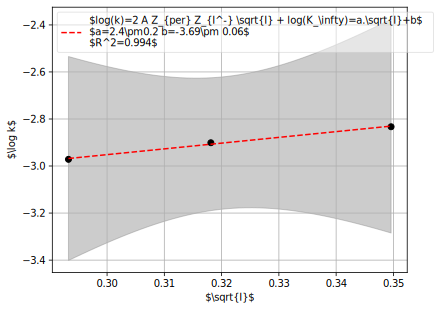

In [ ]:
I = (float(FI_Inicial), float(FI_Inicial), float(FI_Inicial)) + FI_Agregada

VelocidadEXP2 = dfc["C Na2S2O3 (M)"][0]/EXP2/2
k = VelocidadEXP2/(dfc["C K2S2O8 (M)"][0]**m*dfc["C KI (M)"][0]**n)

x = np.sqrt(I)
y = np.log10(k)

ajuste= sm.OLS(y,sm.add_constant(x)).fit()
ord,pend= ajuste.params
err_ord, err_pend= ajuste.bse
r2 = ajuste.rsquared

x_ci = np.linspace(x.min(),x.max(),50)
frame = ajuste.get_prediction(sm.add_constant(x_ci)).summary_frame(alpha=0.01)
ci_low = frame.mean_ci_lower
ci_up = frame.mean_ci_upper

###################################################################################################

fig,axes = plt.subplots()
plt.plot(x, y, "ko")
plt.grid()
plt.xlabel("\$\sqrt{I}\$")
plt.ylabel("\$\log k\$")


linea_x=np.array([x.min(),x.max()])
label_ajuste=r"\$log(k)=2 A Z_{per} Z_{I^-} \sqrt{I} + log(K_\infty)=a.\sqrt{I}+b\$"
label_ajuste+=f"\n\$a={pend:.1f}"+r"\pm"+f"{err_pend:.1g}\tb={ord:.2f}"+"\pm"+f" {err_ord:.1g}\$"
label_ajuste+="\n\$"+r"R^2="+f"{r2:.3f}\$"

plt.plot(linea_x,linea_x*pend+ord , 'r--',label=label_ajuste)
Plot_CI(X=x_ci,CI_lower=ci_low,CI_upper=ci_up)
plt.legend(loc='upper left',fancybox=True, framealpha=0.5)
fig.set_figwidth(0.9*textwidth)
plt.savefig('FI.svg')
files.download('FI.svg')

print(f"I que usamos: {I}")
print(f"I que que pide la guia: {FI_Inicial:.3f}, {FI_1:.3f}, {FI_2:.3f}")

A = 0.51 #mol^(0.5)/dm^(3/2)

k_infinito = 10**ord
err_k_inf = abs((10**ord)*np.log(10))*err_ord
ZaZb = pend/(2*A)
err_ZaZb = err_pend/(2*A)

print(f"{k_infinito = } \pm {err_k_inf:.2g}, {ZaZb = :.3g} \pm {err_ZaZb:.1g}")


#5 y 6 SON TEORICOS, HAY QUE HACERLOS DESPUES BIEN

## Demostracion matematica se cumplen condiciones metodo velocidad inicial
 Algo hice mal, ignorar

In [ ]:

df_exp = pd.DataFrame()
Cp0=df_exp['Cper0']=dfc['C K2S2O8 (M)']
Ci0=df_exp['Ci0']=dfc['C KI (M)']
dt=df_exp['dt']=EXP1
K=k.mean()


a = df_exp['a']=2*Cp0-Ci0
b = (Ci0/(a+Ci0))/np.exp(K*dt*a)



Cif=a*b/(1-b)
df_exp['Cif']=Cif

dC=((df_exp.Ci0-Cif)/df_exp.Ci0)*100
df_exp['dC [%]']=dC
df_exp

,Cper0,Ci0,dt,a,Cif,dC [%]
0,0.038462,0.038462,410,0.038462,0.036973,3.871329
1,0.026923,0.038462,819,0.015385,0.036415,5.320918
2,0.019231,0.038462,1341,0.000000,NaN,NaN
3,0.038462,0.026923,597,0.050000,0.025419,5.586208
4,0.038462,0.019231,779,0.057692,0.017840,7.231390


In [ ]:

datos=pd.DataFrame()
datos['dt_FI']=EXP2
datos['FI_m_KCl']=Masa_AgregadaKCl
datos['FI_Ifinal']= (float(FI_Inicial), float(FI_Inicial), float(FI_Inicial)) + FI_Agregada
datos.to_csv('datos_FI.csv',index=False)

datos=pd.DataFrame()
datos['dt_T']=EXP3
datos['T']=T
datos.to_csv('datos_T.csv',index=False)